In [1]:
#!/bin/python3
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import copy

In [2]:
def stat_errors_total(filename_cc,filename_neutron,geo_corr_file,target_thickness):
    targettype = None
    factor = None
    n_t = None
    delta_n_t = None
    new_density = 1.851
    T_2198 = (new_density)*(2.1928)*(6.02214076)*(pow(10,23))/(12.011);
    T_1086 = (new_density)*(1.0793)*(6.02214076)*(pow(10,23))/(12.011);
    T_54 = (new_density)*(0.5451)*(6.02214076)*(pow(10,23))/(12.011);
    if (target_thickness == "thin"):
        targettype = "c_54"
        factor = (1./T_54)*(pow(10,27))
        n_t = T_54
        delta_n_t = 0.000648
    if (target_thickness == "medium"):
        targettype = "c_1086"
        n_t = T_1086
        delta_n_t = 0.002620
        factor = (1./T_1086)*(pow(10,27))
    if (target_thickness == "thick"):
        targettype = "c_2198"
        n_t = T_2198
        delta_n_t = 0.000322
        factor = (1./T_2198)*(pow(10,27))
        
    ##three dataframes
    ##data frame for charge changing
    df_cc = pd.read_csv(filename_cc,sep='\t',names=["datatype","targettype","RunID","energy","incoming ions","survived_ions"])
    df_cc["d_carbon_survived"] = df_cc["survived_ions"]/df_cc["incoming ions"]
    ##data frame for geo correction
    df_geo = pd.read_csv(geo_corr_file,sep='\t',names=["datatype","targettype","RunID","energy","geo_corr_factor"])
    ### this step of doing the inverse is just needed for twim eff numbers!! DANGEROUS!
    #df_geo["geo_corr_factor"] = 1./df_geo["geo_corr_factor"]
    ##data frame for iso correction
    df_iso = pd.read_csv(filename_neutron,sep='\t',names=["datatype","targettype","RunID","energy","d_reacted_carbon","all_carbon"])
    df_iso["d_12c_survived"] = 1- df_iso["d_reacted_carbon"]
    
    tot_error_val = []
    cc_error_val = []
    iso_error_val = []
    
    cc_cs = []
    cc_cs_geo = []
    iso_cs = []
    total_cs = []
    
    energy_vals = ["400","550","650","800"]
    for ene in energy_vals:
        #charge changing cross section
        dz = (float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived']))/(float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived']))
        cc = factor*(-math.log(dz))
        cc_cs.append(cc)
        #geo corr cross section
        d_geo = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["geo_corr_factor"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["geo_corr_factor"])
        cs_geo = factor*(-math.log(d_geo))
        cc_cs_geo.append(cc+cs_geo)
        #iso cross section = neutron removal
        d_iso = float(df_iso.loc[(df_iso["targettype"] == targettype)& (df_iso["energy"] == float(ene))]["d_12c_survived"])/float(df_iso.loc[(df_iso["targettype"] == "empty")& (df_iso["energy"] == float(ene))]["d_12c_survived"])
        cs_iso = factor*(-math.log(d_iso))
        iso_cs.append(cs_iso)
        tot_cs = cc + cs_geo + cs_iso
        total_cs.append(tot_cs)
        #print("charge changing cross section: ",cc)
        #print("geo corr cross section: ", cs_geo)
        #print("iso cross section:", cs_iso)
        ##now doing the stat. uncertainty calculations
        
        ### target thickness uncertainty
        target_error = pow(tot_cs*delta_n_t,2)
        
        ### charge changing uncertainties
        r_cc_target = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        r_cc_empty = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        n_i_t_cc = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['incoming ions'])
        n_i_e_cc = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['incoming ions'])
        cc_error = (pow(10,54))*(1./(n_t*n_t))*((1-r_cc_target)/(r_cc_target*n_i_t_cc)+(1-r_cc_empty)/(r_cc_empty*n_i_e_cc))
        #print("cc_error:  ",cc_error)
        ### iso correction uncertainties
        r_iso_target = float(df_iso.loc[(df_iso["targettype"] == targettype) & (df_iso["energy"] == float(ene))]['d_12c_survived']) 
        r_iso_empty = float(df_iso.loc[(df_iso["targettype"] == "empty") & (df_iso["energy"] == float(ene))]['d_12c_survived'])
        n_i_t_iso = float(df_iso.loc[(df_iso["targettype"] == targettype) & (df_iso["energy"] == float(ene))]['all_carbon'])
        n_i_e_iso = float(df_iso.loc[(df_iso["targettype"] == "empty") & (df_iso["energy"] == float(ene))]['all_carbon'])
        iso_error = (pow(10,54))*(1./(n_t*n_t))*((1-r_iso_target)/(r_iso_target*n_i_t_iso)+(1-r_iso_empty)/(r_iso_empty*n_i_e_iso))
        #print("iso errror: ", math.sqrt(iso_error))
        #print("target_error:  ",math.sqrt(target_error))
        #print("cc_error: ", math.sqrt(cc_error+target_error))
        
        
        tot_error = math.sqrt(target_error + cc_error + iso_error)
        #print("total error\t",tot_error)
        tot_error_val.append(tot_error)
    return total_cs,tot_error_val

### using as geo correction total twim efficiency
---

/tmp/ipykernel_45940/1461302224.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dz = (float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived']))/(float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived']))
/tmp/ipykernel_45940/1461302224.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  d_geo = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["geo_corr_factor"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["geo_corr_factor"])
/tmp/ipykernel_45940/1461302224.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  d

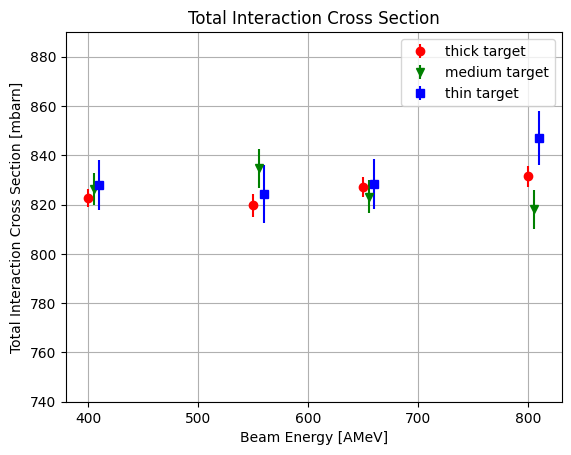

In [3]:
test_cc = 'numbers/comb_gauss2d_border.txt'
#filename_geo_corr = "orig_geo_corr_factor.txt"
filename_geo_corr = "total_eff_twim.txt"
filename_iso_cs = "./with_stats_iso_corr/stats_inc_mw23_quad4_own_clustering.txt"


total_cs_thin, full_error_val_thin = stat_errors_total(test_cc,filename_iso_cs,filename_geo_corr, "thin")
total_cs_medium, full_error_val_medium = stat_errors_total(test_cc,filename_iso_cs,filename_geo_corr, "medium")
total_cs_thick, full_error_val_thick = stat_errors_total(test_cc,filename_iso_cs,filename_geo_corr, "thick")

fig, ax = plt.subplots()
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,total_cs_thick,yerr=full_error_val_thick,label="thick target",color='red',marker="o",fmt="o")

energy = [405,555,655,805]
ax.errorbar(energy,total_cs_medium,yerr=full_error_val_medium,label="medium target",color='green',marker="v",fmt="o")

energy = [410,560,660,810]
ax.errorbar(energy,total_cs_thin,yerr=full_error_val_thin,label="thin target",color='blue',marker="s",fmt="o")

ax.legend()
ax.grid()
ax.set_xlabel("Beam Energy [AMeV]")
ax.set_ylabel("Total Interaction Cross Section [mbarn]")
ax.set_title("Total Interaction Cross Section")
ax.set_ylim(740,890)
plt.savefig("tot_interaction_cs_twim_eff_corr.png")

---

### using as geo correction the geometric cuts/reconstructions
---

/tmp/ipykernel_45940/1461302224.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dz = (float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived']))/(float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived']))
/tmp/ipykernel_45940/1461302224.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  d_geo = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["geo_corr_factor"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["geo_corr_factor"])
/tmp/ipykernel_45940/1461302224.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  d

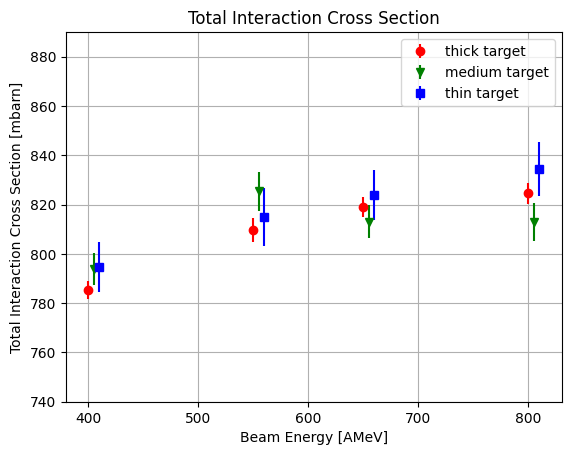

In [4]:
test_cc = 'numbers/comb_gauss2d_border.txt'
filename_geo_corr = "orig_geo_corr_factor.txt"
#filename_geo_corr = "total_eff_twim.txt"
filename_iso_cs = "./with_stats_iso_corr/stats_inc_mw23_quad4_own_clustering.txt"


total_cs_thin, full_error_val_thin = stat_errors_total(test_cc,filename_iso_cs,filename_geo_corr, "thin")
total_cs_medium, full_error_val_medium = stat_errors_total(test_cc,filename_iso_cs,filename_geo_corr, "medium")
total_cs_thick, full_error_val_thick = stat_errors_total(test_cc,filename_iso_cs,filename_geo_corr, "thick")

fig, ax = plt.subplots()
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,total_cs_thick,yerr=full_error_val_thick,label="thick target",color='red',marker="o",fmt="o")

energy = [405,555,655,805]
ax.errorbar(energy,total_cs_medium,yerr=full_error_val_medium,label="medium target",color='green',marker="v",fmt="o")

energy = [410,560,660,810]
ax.errorbar(energy,total_cs_thin,yerr=full_error_val_thin,label="thin target",color='blue',marker="s",fmt="o")

ax.legend()
ax.grid()
ax.set_xlabel("Beam Energy [AMeV]")
ax.set_ylabel("Total Interaction Cross Section [mbarn]")
ax.set_title("Total Interaction Cross Section")
ax.set_ylim(740,890)
plt.savefig("tot_interaction_cs_geo_corr.png")

---